In [77]:
# Version 2025-07-28

# All basis code provided by H&M
# Edited by Patrik Johansson
# Imported functions are created by H&M unless open source
import sys
sys.path.append('/home/jupyter/')
import os

import numpy as np
import pandas as pd
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

# Special methods written by H&M
from stats import reqSS_means
from plotting import plot_summary

from numpy.random import default_rng

colors = sns.color_palette()

In [78]:
alpha = 0.05 # significance level
beta = 0.2 # type 2 error rate, test power is 1 - beta
mde = 0.05 # 0.01 and 0.05 optimally, but was at start = 0.1

# control group
mu_c = 3
var_c = 1
# treatment group
mu_t = mu_c*(1.+(mde))
var_t = 1


# number of observations for control
nobs_c = reqSS_means(mu_c, var_c, mde, alpha, beta, direction = "two-sided")
# nobs_c = 1000*(nobs_c//1000)+1000
nobs_c_x2 = nobs_c*2

# number of observations for treatment 
nobs_t = reqSS_means(mu_c, var_c, mde, alpha, beta, direction = "two-sided")
# nobs_t = 1000*(nobs_t//1000)+1000
nobs_t_x2 = nobs_t*2

# number of experiments
n_exps = 200

# obs_step = 100

# alternative: two-sided, less, greater
alternative = "two-sided"

In [79]:
rand_gen = default_rng(seed=42)

In [80]:
def sampling(distribution, transformation, control, treatment, nobs):
    a_data = rand_gen.normal(control, np.sqrt(control), nobs)
    aa_data = rand_gen.normal(control, np.sqrt(control), nobs)
    ab_data = rand_gen.normal(treatment, np.sqrt(treatment), nobs)

In [157]:
def ab_test(dist, trans, mod, nobs, mean, var, mde, n_exps, chosen_seed, seed_change):
    rand_gen = default_rng(seed=chosen_seed)

    pvalues_aa = []
    pvalues_ab = []

    """
    print("AB_TEST")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"nobs = {nobs}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"mde = {mde}")
    print(f"n_exps = {n_exps}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"seed_change = {seed_change}")
    print("\n")
    """

    treatment = mean*(1.+(mde))


    for exp_num in range(n_exps):
        
        if (seed_change > 0) and (exp_num != 0):
            chosen_seed += seed_change
            rand_gen = default_rng(seed=chosen_seed)

        #generate_data
        if dist == "Poisson":
            a_data = rand_gen.poisson(mean, int(nobs))
            aa_data = rand_gen.poisson(mean, int(nobs))
            ab_data = rand_gen.poisson(treatment, int(nobs))
        elif dist == "Discrete Uniform":
            a_data = rand_gen.integers(np.round((mean - 3*var), 0), np.round((mean + 3*var + 1), 0), int(nobs))
            aa_data = rand_gen.integers(np.round((mean - 3*var), 0), np.round((mean + 3*var + 1), 0), int(nobs))
            ab_data = rand_gen.integers(np.round(((treatment) - 3*var), 0), np.round(((treatment) + 3*var + 1), 0), int(nobs))
        elif dist == "Laplace":
            a_data = rand_gen.normal(mean, np.sqrt(var/2), int(nobs))
            aa_data = rand_gen.normal(mean, np.sqrt(var/2), int(nobs))
            ab_data = rand_gen.normal(treatment, np.sqrt(var/2), int(nobs))
        else: # Normal distribution by default
            a_data = rand_gen.normal(mean, np.sqrt(var), int(nobs))
            aa_data = rand_gen.normal(mean, np.sqrt(var), int(nobs))
            ab_data = rand_gen.normal(treatment, np.sqrt(var), int(nobs))
        
        # cast arrays to handle transformations with changes
        a_data = np.array(a_data, dtype=float)
        aa_data = np.array(aa_data, dtype=float)
        ab_data = np.array(ab_data, dtype=float)

        # modify data for transformation
        if mod == 0:
            a_data[a_data <= 0] = 1
            aa_data[aa_data <= 0] = 1
            ab_data[ab_data <= 0] = 1
        elif mod == 1 or mod == 11:
            if np.min(a_data) < -1:
                a_data += ((-1*np.min(a_data))-0.99)
            if np.min(aa_data) < -1:
                aa_data += ((-1*np.min(aa_data))-0.99)
            if np.min(ab_data) < -1:
                ab_data += ((-1*np.min(ab_data))-0.99)
            a_data += 1
            aa_data += 1
            ab_data += 1
        elif mod == 10:
            a_data[a_data <= 0] = 1e-10
            aa_data[aa_data <= 0] = 1e-10
            ab_data[ab_data <= 0] = 1e-10


        # action based on transformation used
        if trans == "Log" or trans == "Logarithmic":
            a_data = np.log(a_data)
            aa_data = np.log(aa_data)
            ab_data = np.log(ab_data) 
        elif trans == "BC" or trans == "Box-Cox":
            a_data, a_lambda = st.boxcox(a_data)
            aa_data, aa_lambda = st.boxcox(aa_data)
            ab_data, ab_lambda = st.boxcox(ab_data)

        # 11 is heuristical approach where first an addition before transformation
        # then subtracts of points after transformation
        if mod == 11:
            a_data -= 1
            aa_data -= 1
            ab_data -= 1  
  
        
        pvalues_ab.append(
            st.ttest_ind(a_data, ab_data).pvalue
        )
        pvalues_aa.append(
            st.ttest_ind(a_data, aa_data).pvalue
        )

    pvalues_ab = np.array(pvalues_ab)
    pvalues_aa = np.array(pvalues_aa)

    return pvalues_ab, pvalues_aa

In [162]:
def approximate_points(dist, trans, mod, mean, var, points, chosen_seed, mde, alpha, beta, direction):

    """
    # Prints values
    print("APPROXIMATE_POINTS")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"points = {points}")
    print(f"mde = {mde}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"alpha = {alpha}")
    print(f"beta = {beta}")
    print(f"direction = {direction}")
    print("\n")
    """

    ref_data = []

    # Sets seed
    rand_gen = default_rng(seed=chosen_seed)

    if (trans == "Log" or trans == "Logarithmic") or (trans == "BC" or trans == "Box-Cox"):

        newer_mean = mean*(1.+mde)

        if dist == "Poisson":
            ref_data = rand_gen.poisson(newer_mean, int(points))
        elif dist == "Discrete Uniform":
            ref_data = rand_gen.integers(np.round((newer_mean - 3*var), 0), np.round((newer_mean + 3*var + 1), 0), int(points))
        elif dist == "Laplace":
            ref_data = rand_gen.laplace(newer_mean, np.sqrt(var), int(points))
            print(np.min(ref_data))
        else: # Normal distribution by default
            ref_data = rand_gen.normal(newer_mean, np.sqrt(var), int(points))

        ref_data = np.array(ref_data, dtype=float)
        

    if dist == "Poisson":
        data = rand_gen.poisson(mean, int(points))
    elif dist == "Discrete Uniform":
        data = rand_gen.integers(np.round((mean - 3*var), 0), np.round((mean + 3*var + 1), 0), int(points))
    elif dist == "Laplace":
        data = rand_gen.laplace(mean, np.sqrt((var/2)), int(points))
        print(np.min(data))
    else: # Normal distribution by default
        data = rand_gen.normal(mean, np.sqrt(var), int(points))
        
    data = np.array(data, dtype=float)

    #count, bins, ignored = plt.hist(data, 30, density = True)
    #plt.show()
    

    # No modification by default
    if mod == 0:
        data[data <= 0] = 1
        if len(ref_data) != 0:
            ref_data[ref_data <= 0] = 1
    elif mod == 1 or mod == 11:
        if np.min(data) <= -1:
            data += ((-1*np.min(data))-0.99)
        data += 1
        if len(ref_data) != 0:
            if np.min(ref_data) <= -1:
                ref_data += ((-1*np.min(ref_data))-0.99)
            ref_data += 1
        print(data)
        print(ref_data)
    elif mod == 10:
        data[data <= 0] = 1e-10
        if len(ref_data) != 0:
            ref_data[ref_data <= 0] = 1e-10
        

    # No transformation by default
    if trans == "Log" or trans == "Logarithmic":
        data = np.log(data)
        if len(ref_data) != 0:
            ref_data = np.log(ref_data)

    elif trans == "BC" or trans == "Box-Cox":
        data, data_lambda = st.boxcox(data)
        if len(ref_data) != 0:
            ref_data, ref_data_lambda = st.boxcox(ref_data)
    

    # Heuristical modification
    if mod == 11:
        data -= 1
        if len(ref_data) != 0:
            ref_data -= 1
    
    if len(ref_data) != 0:
        mde = ((ref_data.mean() - data.mean())/ data.mean())
        print(f"mde = {mde}") #but is negative mde correct? ex resp10 with log gave -1.09 in mde?

    mean_value = np.mean(data)
    variance = np.var(data)
    print(f"variance = {variance}")

    if mod == 1:
        print(reqSS_means(mean_value, variance, mde, alpha, beta, direction = "two-sided"))
        
    if direction == "greater":
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "greater")
    if direction == "less":
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "less")
    else:
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "two-sided")
        

In [159]:
def complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, nexps):

    """
    # Prints values
    print("COMPLETE TEST")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"points = {points}")
    print(f"nobs = {nobs}")
    print(f"mde = {mde}")
    print(f"alpha = {alpha}")
    print(f"beta = {beta}")
    print(f"direction = {direction}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"seed_change = {seed_change}")
    print(f"n_exps = {nexps}")
    print("\n")
    """

    if nobs == 0:
        nobs = approximate_points(dist, trans, mod, mean, var, points, chosen_seed, mde, alpha, beta, direction)
        """
        # Prints values
        print("\n")
        print(f"new nobs = {nobs}")
        print("\n")
        """
    resultab, resultaa = ab_test(dist, trans, mod, nobs, mean, var, mde, nexps, chosen_seed, seed_change)
    return [resultab, resultaa, nobs]
    


In [123]:
# Keywords to use
normal = "Normal"
poisson = "Poisson"
duniform = "Discrete Uniform"
laplace = "Laplace"
bc = "BC"
log = "Log"

# Method arguments that could be easily adjused to purpose
dist = ""
trans = ""
mod = -1
mean = 3
var = 1
points = 1e7
nobs = 0
mde = 0.05
alpha = 0.05
beta = 0.2
direction = "two-sided"
chosen_seed = 42
seed_change = 1
n_exps = 200

# Below are all runs with the specific functions.

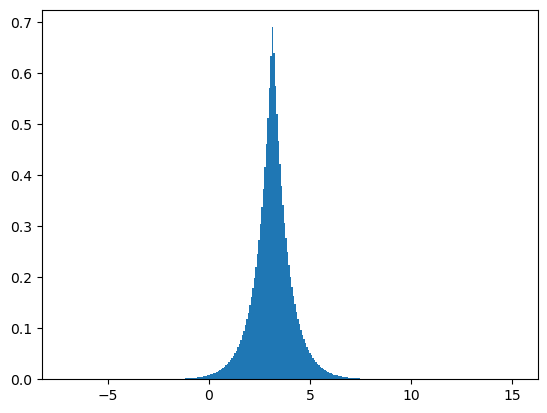

In [149]:
newer_mean = mean*(1.+mde)
ref_data = rand_gen.laplace((newer_mean), np.sqrt(var/2), int(points))
count, bins, ignored = plt.hist(ref_data, 300, density = True)
plt.show()

In [163]:
nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(laplace, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(laplace, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(laplace, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(laplace, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(laplace, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 0.9994814976396007
-8.350656120497703
variance = 1.0001692100259802
-12.90225182744103
-7.925823433496721
mde = 0.013253461687025386
variance = 0.17625311382768596
-12.90225182744103
-7.925823433496721
[11.11563315 10.89880782 10.87552788 ... 10.9822409   9.62623334
 11.24049171]
[16.85613047 15.9318662  17.32525246 ... 17.29855564 18.71116511
 16.01385776]
mde = 0.1611070302680326
variance = 0.008773667563127531
1
-12.90225182744103
-7.925823433496721
mde = -0.3605655593814499
variance = 4.287425141146581
-12.90225182744103
-7.925823433496721
[11.11563315 10.89880782 10.87552788 ... 10.9822409   9.62623334
 11.24049171]
[16.85613047 15.9318662  17.32525246 ... 17.29855564 18.71116511
 16.01385776]
mde = 0.2771950034928244
variance = 0.00877366756312753


In [38]:
#print(resn[0]) #Checks that the ab-values are correctly handeled
#print(resn[1]) #Checks that the aa-values are correctly handeled
#print(resn[2]) #Checks that the nobs is correctly handeled
#print(resp[1][0])
#print(resp[1][1])


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

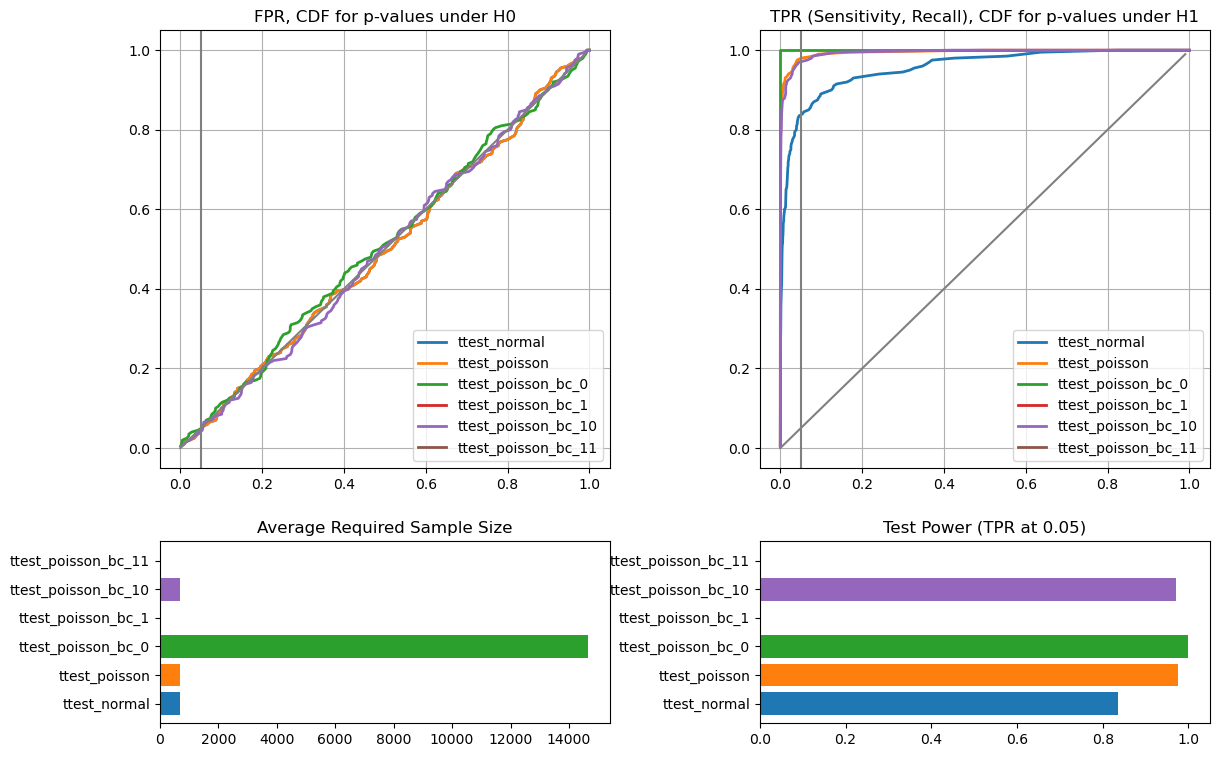

In [161]:
# First graph, + mde at fixed nobs for all bc methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [40]:
# Now the same but with log instead
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

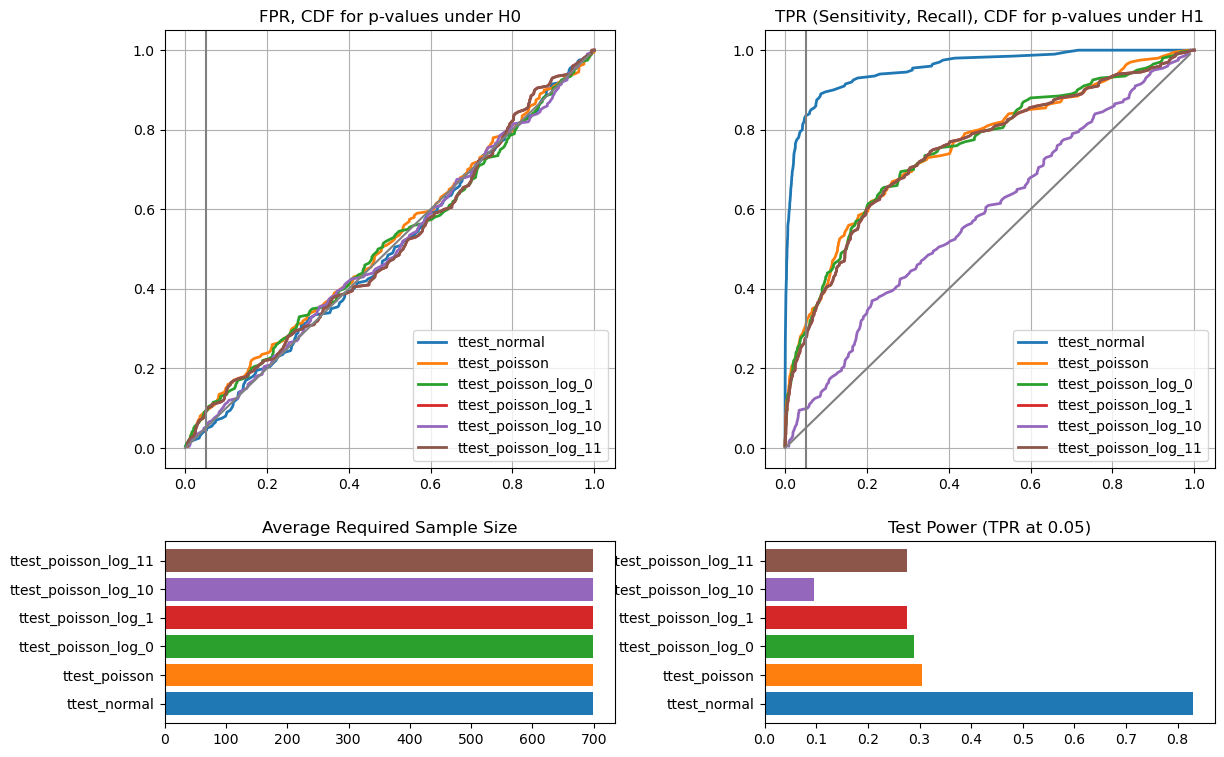

In [41]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [42]:
# Now the same but nobs = 0 so that it calculates the amounts it needs.
nobs = 0
resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.08998248015664444
mde = 0.049347347917587873
mde = 0.09236029204580275
mde = 0.10301736207674812


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

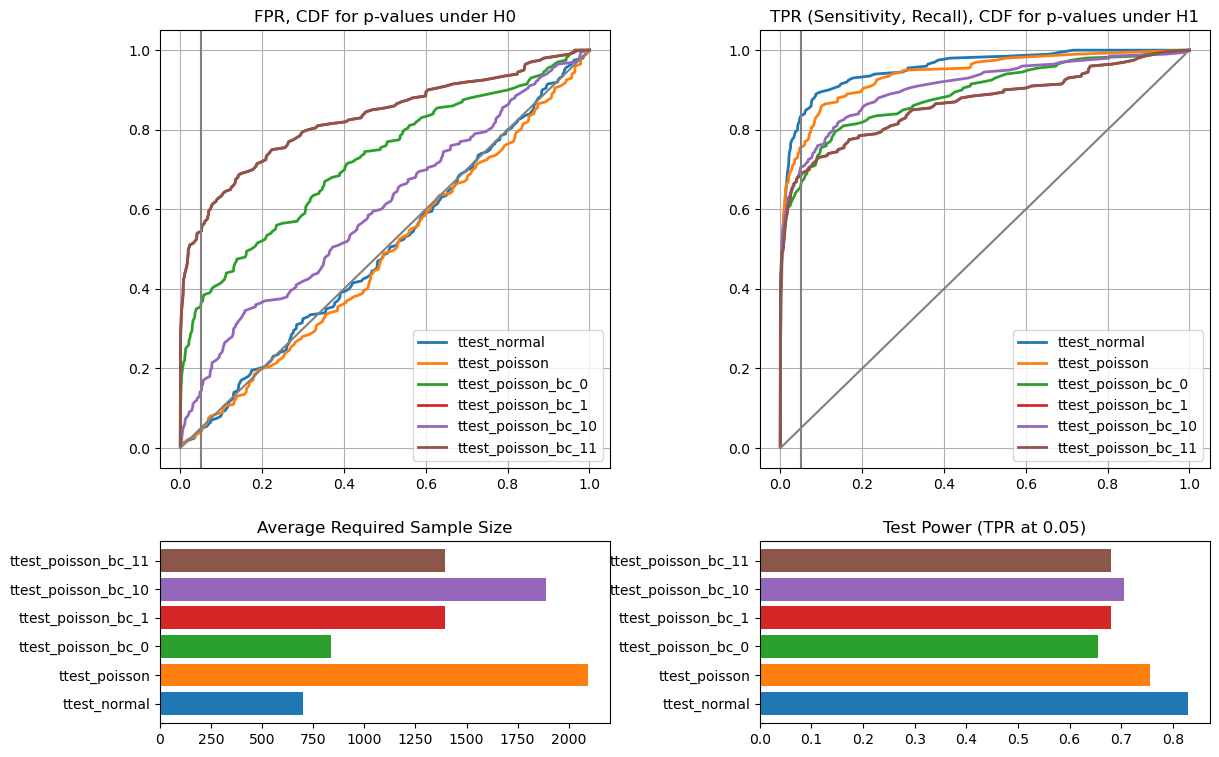

In [43]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [44]:
# Now the same but with log instead and nobs = 0

nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.04941743757194689
mde = 0.029758182181639576
mde = -1.0390048921042416
mde = 0.13554150026706321


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

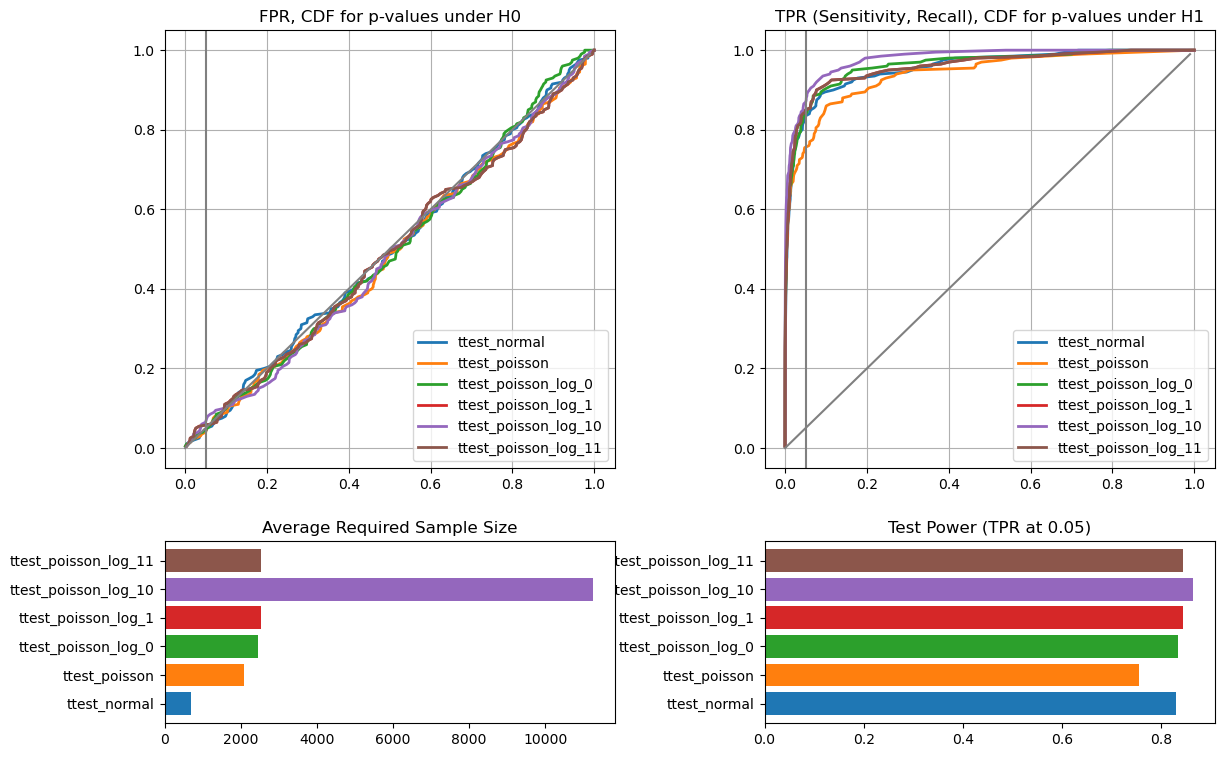

In [45]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [46]:
# Same but without the high log-approximation
nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.04941743757194689
mde = 0.029758182181639576
mde = 0.13554150026706321


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

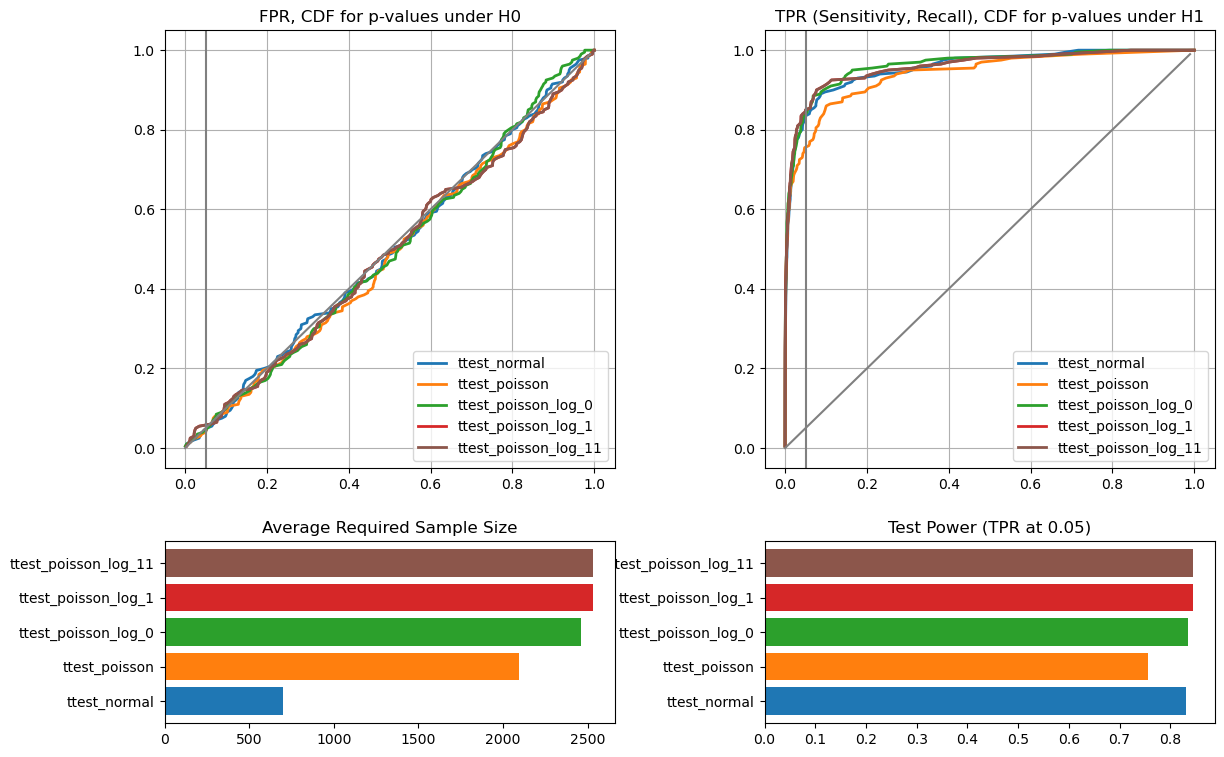

In [47]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    #"ttest_poisson_log_10": (
    #    resp10[0],
    #    resp10[1],
    #    resp10[2],
    #    colors[4]
    #),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [48]:
# Now for discrete uniform
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd0 = complete_test(duniform, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd1 = complete_test(duniform, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd10 = complete_test(duniform, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd11 = complete_test(duniform, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

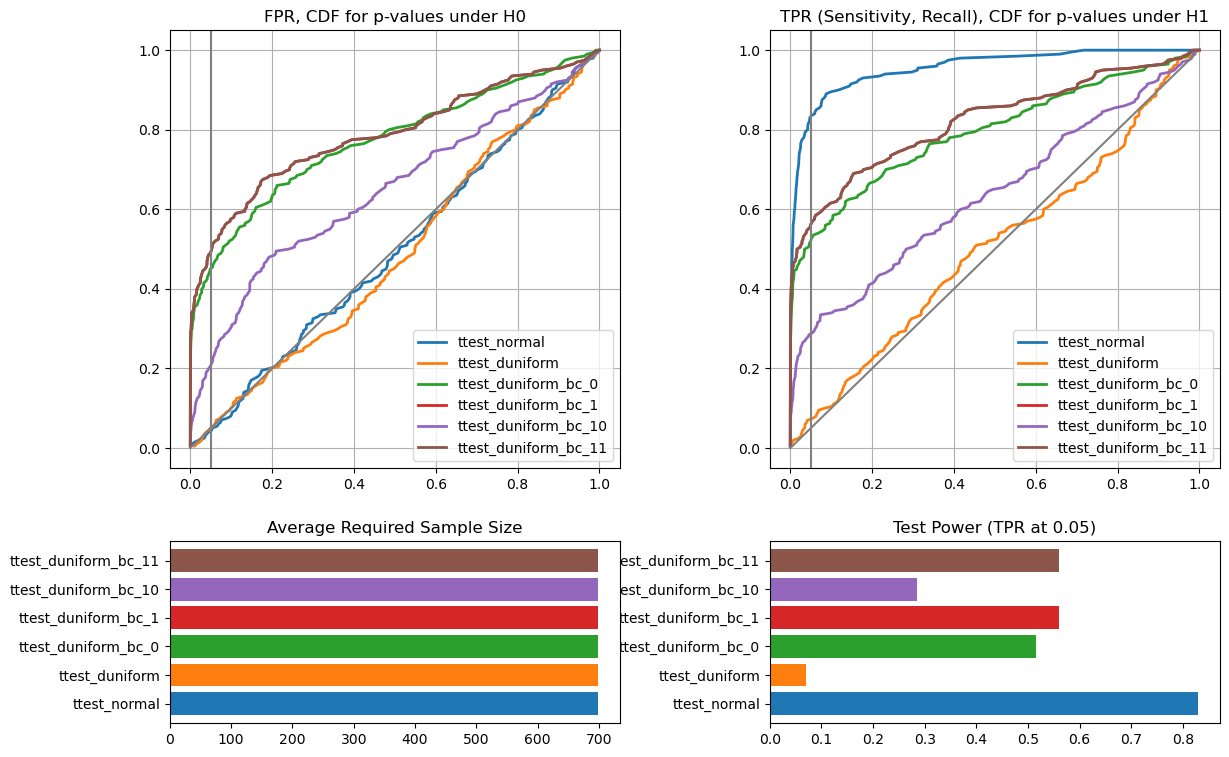

In [49]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_duniform": (
        resd[0],
        resd[1],
        resd[2],
        colors[1]
    ),
    "ttest_duniform_bc_0": (
        resd0[0],
        resd0[1],
        resd0[2],
        colors[2]
    ),
    "ttest_duniform_bc_1": (
        resd1[0],
        resd1[1],
        resd1[2],
        colors[3]
    ),
    "ttest_duniform_bc_10": (
        resd10[0],
        resd10[1],
        resd10[2],
        colors[4]
    ),
    "ttest_duniform_bc_11": (
        resd11[0],
        resd11[1],
        resd11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [68]:
# Now for discrete uniform log
mde = 0.05
mean = 3
var = 1
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd0 = complete_test(duniform, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd1 = complete_test(duniform, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd10 = complete_test(duniform, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd11 = complete_test(duniform, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

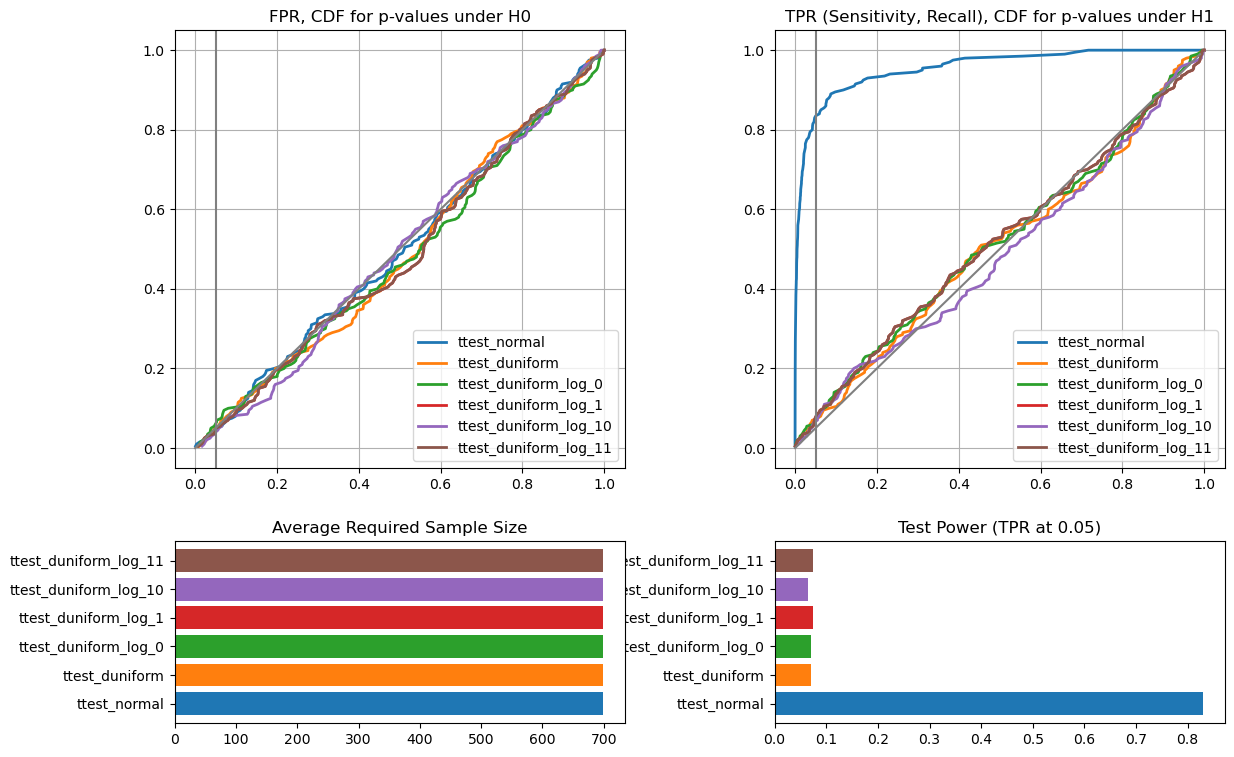

In [69]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_duniform": (
        resd[0],
        resd[1],
        resd[2],
        colors[1]
    ),
    "ttest_duniform_log_0": (
        resd0[0],
        resd0[1],
        resd0[2],
        colors[2]
    ),
    "ttest_duniform_log_1": (
        resd1[0],
        resd1[1],
        resd1[2],
        colors[3]
    ),
    "ttest_duniform_log_10": (
        resd10[0],
        resd10[1],
        resd10[2],
        colors[4]
    ),
    "ttest_duniform_log_11": (
        resd11[0],
        resd11[1],
        resd11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [52]:
# Now for discrete uniform log with their own deciding nobs
nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd0 = complete_test(duniform, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd1 = complete_test(duniform, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd10 = complete_test(duniform, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd11 = complete_test(duniform, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = -0.0025833062557166623
mde = -0.0021863353580623885
mde = -0.005979672268622758
mde = -0.003928599001174849


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

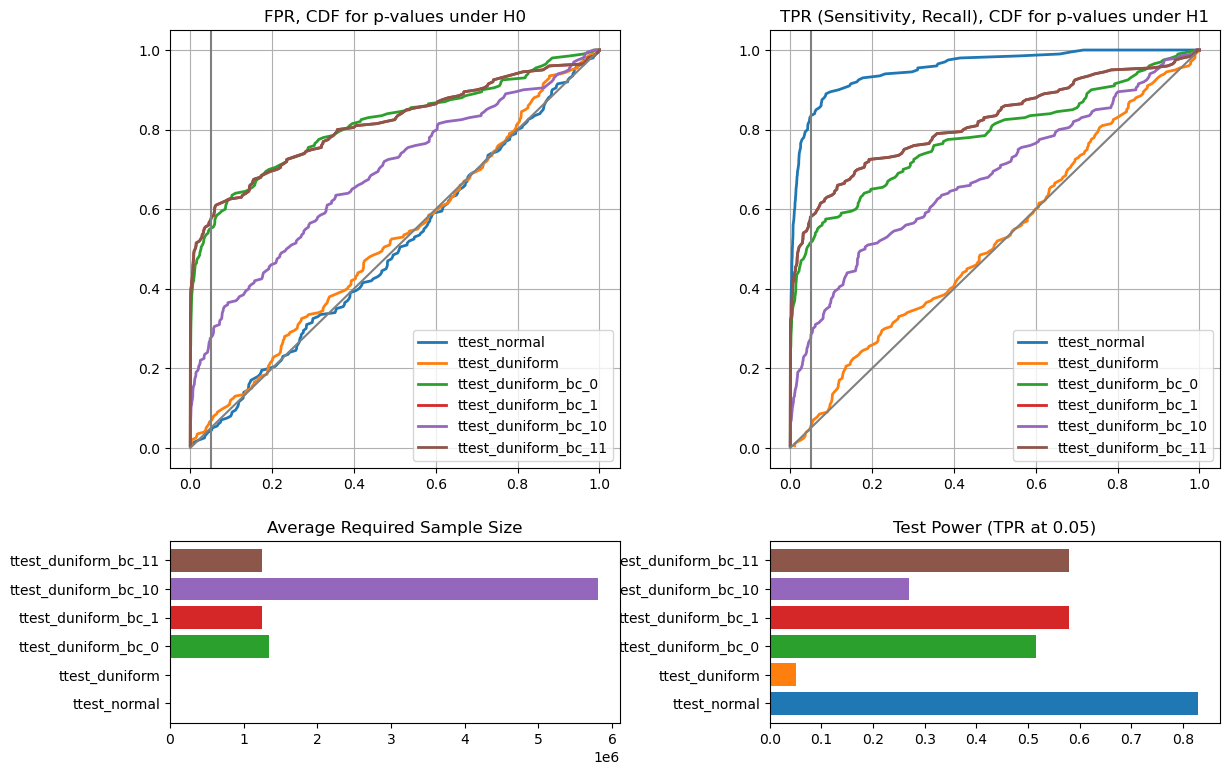

In [53]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_duniform": (
        resd[0],
        resd[1],
        resd[2],
        colors[1]
    ),
    "ttest_duniform_bc_0": (
        resd0[0],
        resd0[1],
        resd0[2],
        colors[2]
    ),
    "ttest_duniform_bc_1": (
        resd1[0],
        resd1[1],
        resd1[2],
        colors[3]
    ),
    "ttest_duniform_bc_10": (
        resd10[0],
        resd10[1],
        resd10[2],
        colors[4]
    ),
    "ttest_duniform_bc_11": (
        resd11[0],
        resd11[1],
        resd11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [67]:
# Now for discrete uniform log with their own approximations
nobs = 0
n_exps = 200
mean = 3
var = 1
mde = 0.05

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd0 = complete_test(duniform, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd1 = complete_test(duniform, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd10 = complete_test(duniform, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd11 = complete_test(duniform, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = -0.0009478971194773271


KeyboardInterrupt: 

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

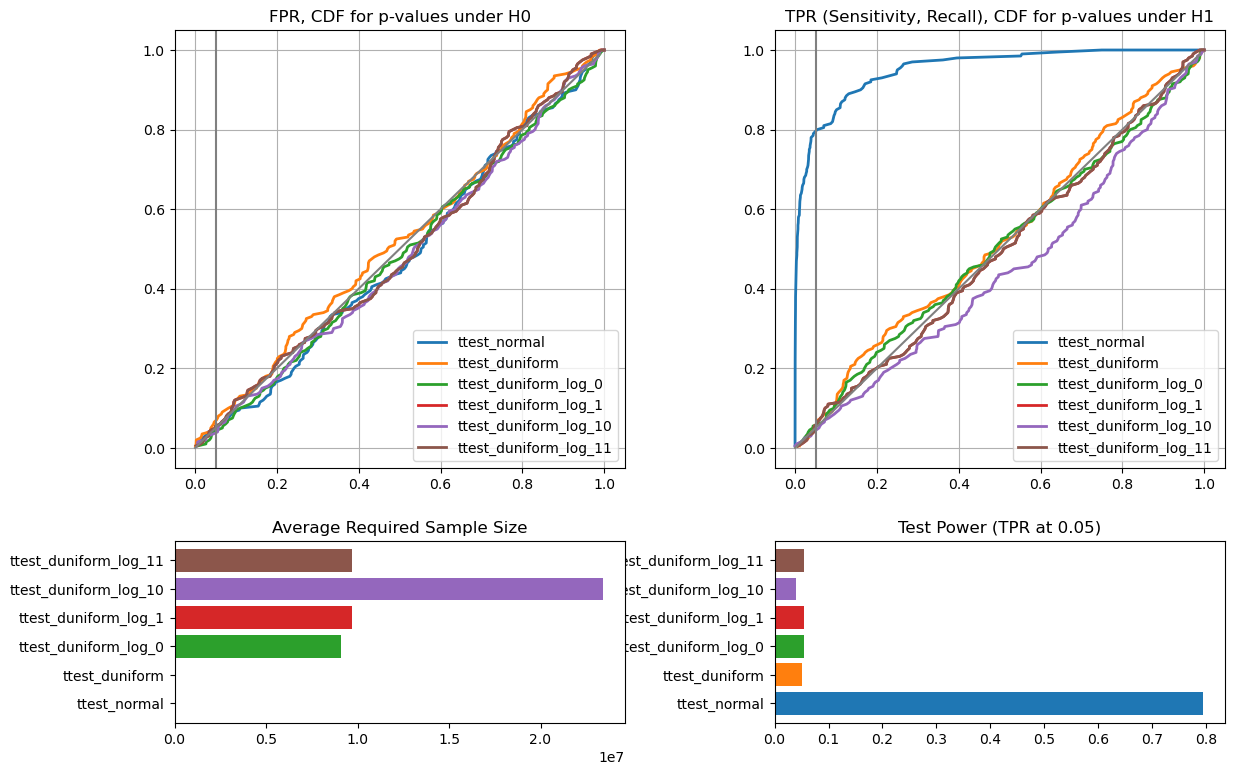

In [ ]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_duniform": (
        resd[0],
        resd[1],
        resd[2],
        colors[1]
    ),
    "ttest_duniform_log_0": (
        resd0[0],
        resd0[1],
        resd0[2],
        colors[2]
    ),
    "ttest_duniform_log_1": (
        resd1[0],
        resd1[1],
        resd1[2],
        colors[3]
    ),
    "ttest_duniform_log_10": (
        resd10[0],
        resd10[1],
        resd10[2],
        colors[4]
    ),
    "ttest_duniform_log_11": (
        resd11[0],
        resd11[1],
        resd11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [56]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

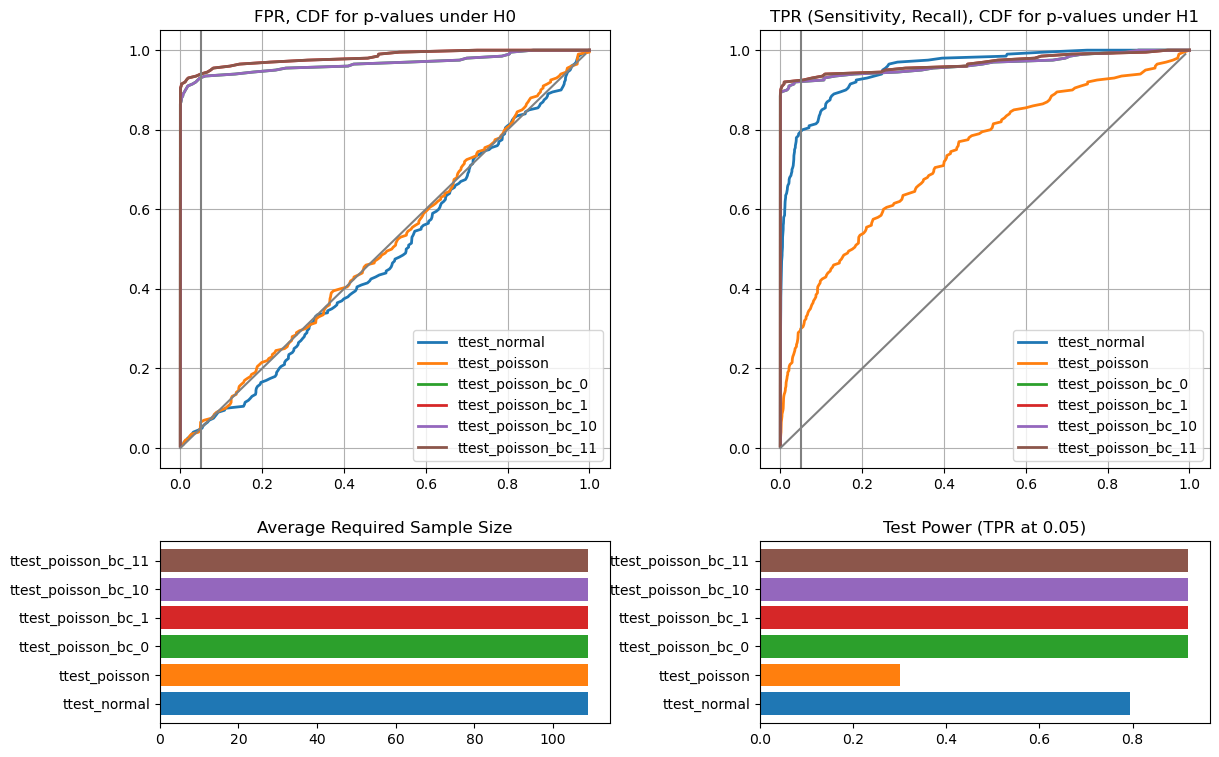

In [57]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [58]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.039673937950855394
mde = 0.038981886314637997
mde = 0.039673937950855394
mde = 0.044796652824527224


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

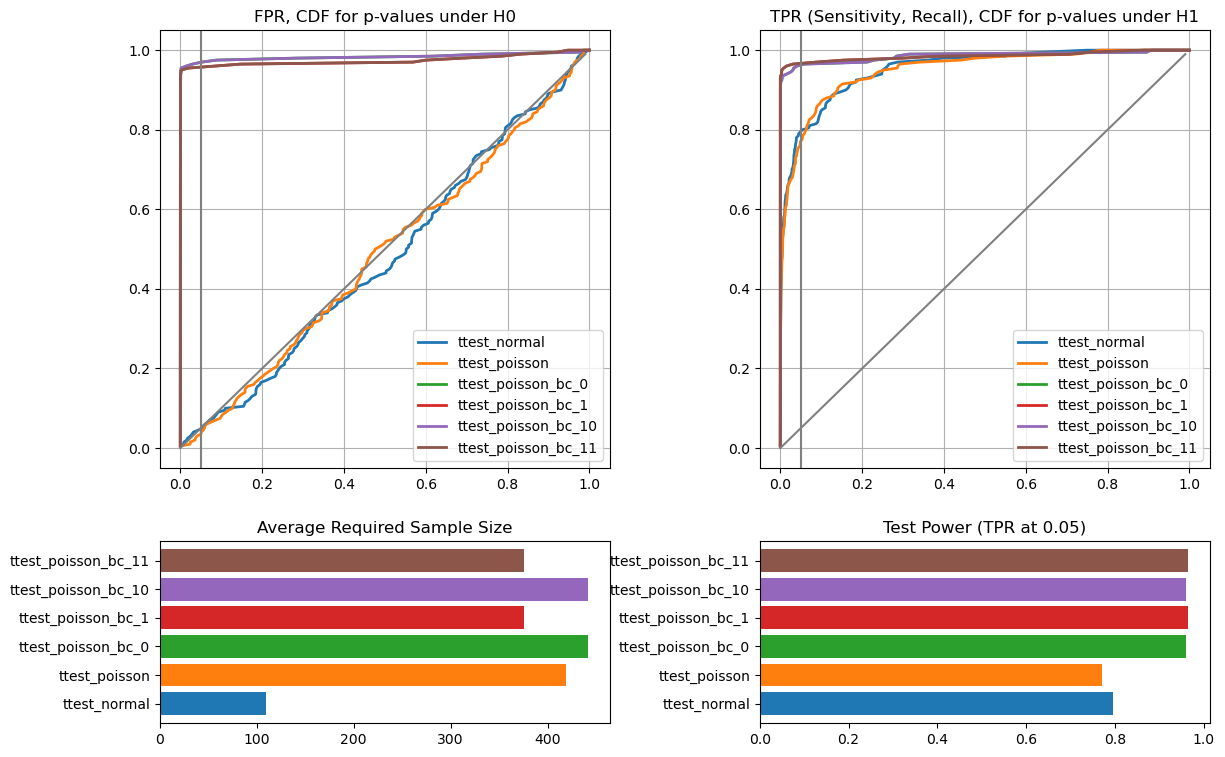

In [59]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [ ]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

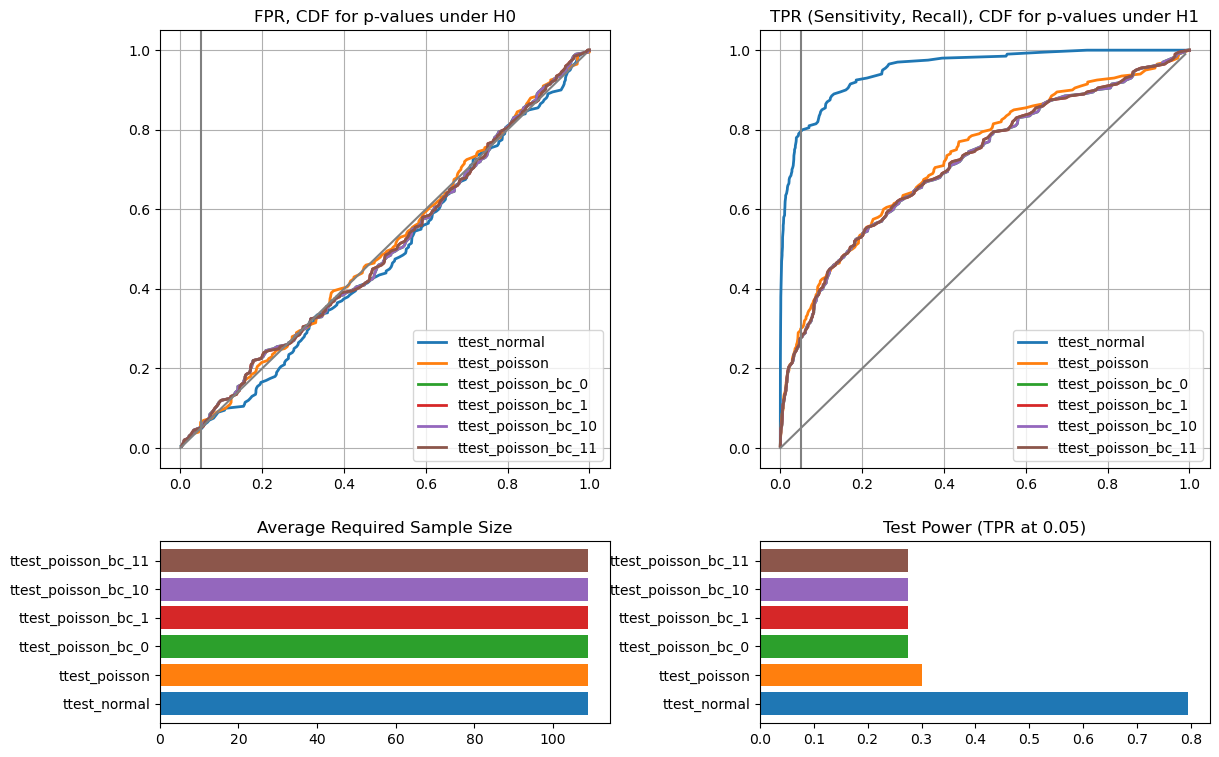

In [61]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [62]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.018679307995438293
mde = 0.01697323887391731
mde = 0.018679307995438293
mde = 0.026716968831260436


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

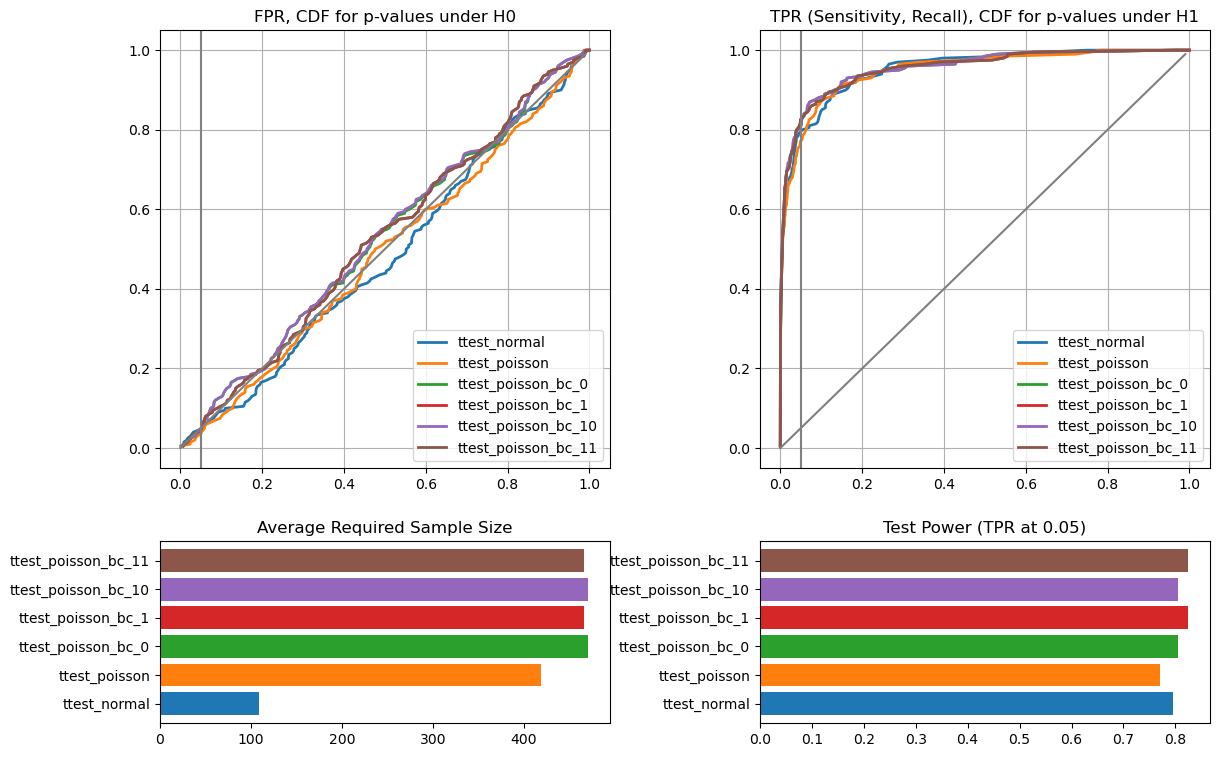

In [63]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [64]:
# But, no modifications should be valid here as well!!!

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respb00 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respl00 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

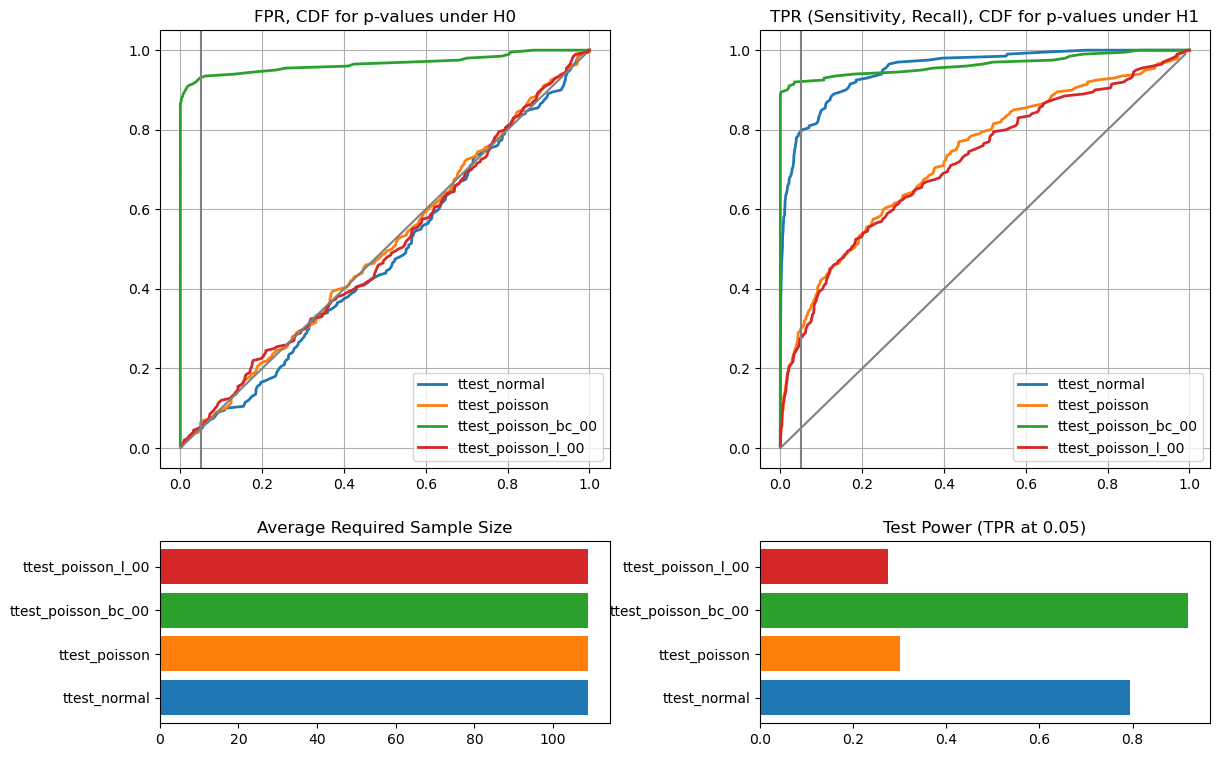

In [65]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_00": (
        respb00[0],
        respb00[1],
        respb00[2],
        colors[2]
    ),
    "ttest_poisson_l_00": (
        respl00[0],
        respl00[1],
        respl00[2],
        colors[3]
    )
}
_ = plot_summary(test_res)

In [66]:
# But, no modifications should be valid here as well!!!

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respb00 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respl00 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.039673937950855394
mde = 0.018679307995438293


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

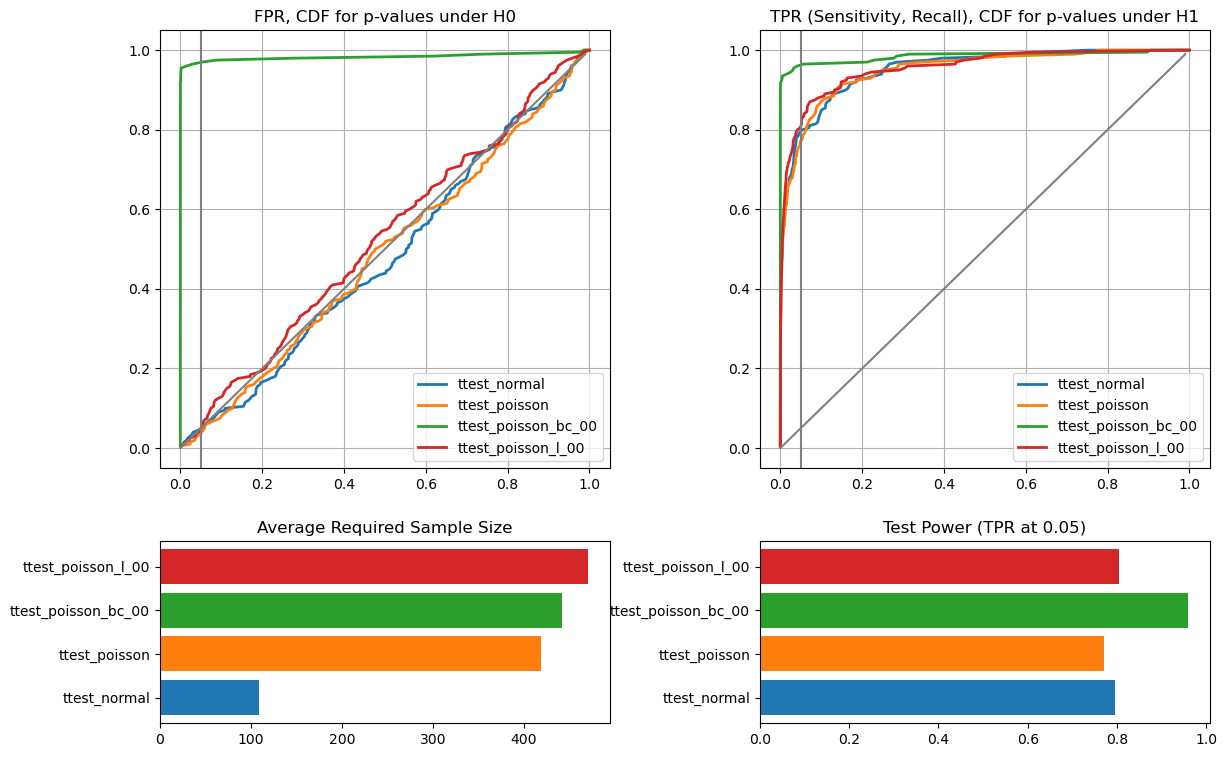

In [67]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_00": (
        respb00[0],
        respb00[1],
        respb00[2],
        colors[2]
    ),
    "ttest_poisson_l_00": (
        respl00[0],
        respl00[1],
        respl00[2],
        colors[3]
    )
}
_ = plot_summary(test_res)

In [69]:
# Approximation with better MDE and bc log for mean = 3 and var = 1

mean = 3
var = 1
mde = 0.01

# Now the same but with log instead
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

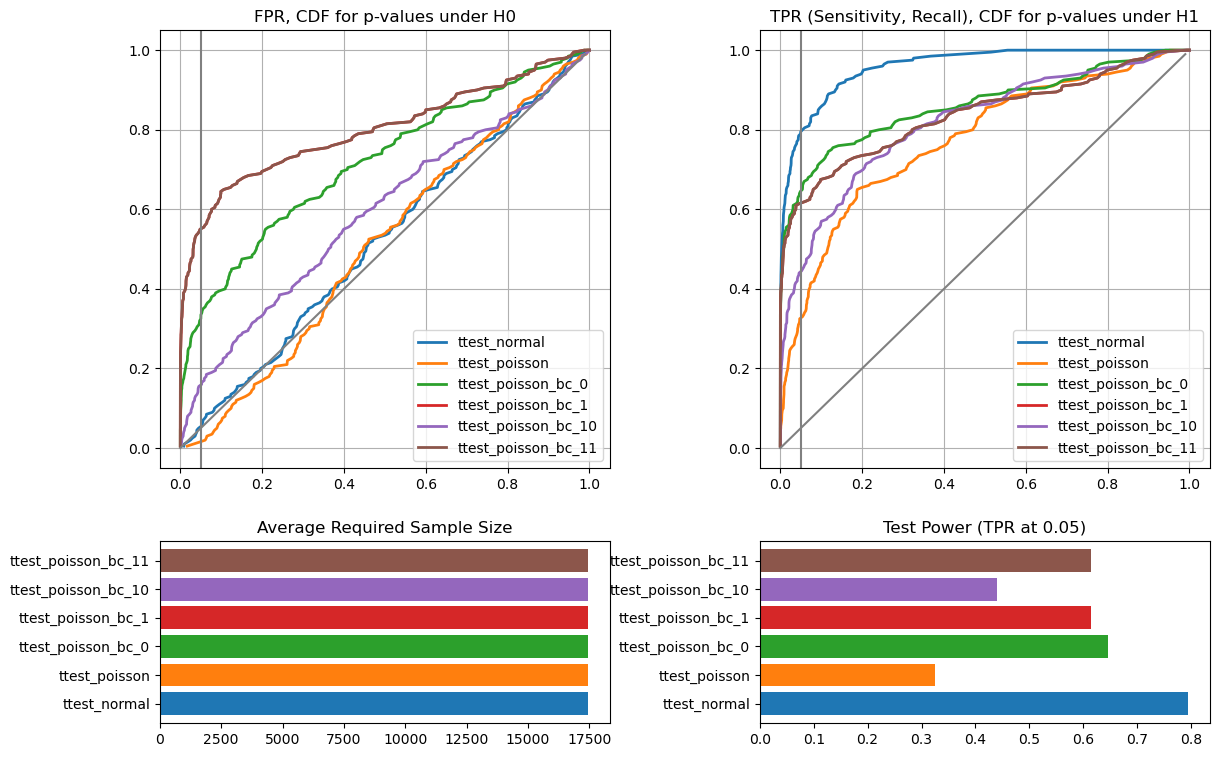

In [70]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [71]:
nobs = 0 #Now they approximate themselves
resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.015906198626388344
mde = 0.008172029013297792
mde = 0.017286747640302778
mde = 0.017053886936437966


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

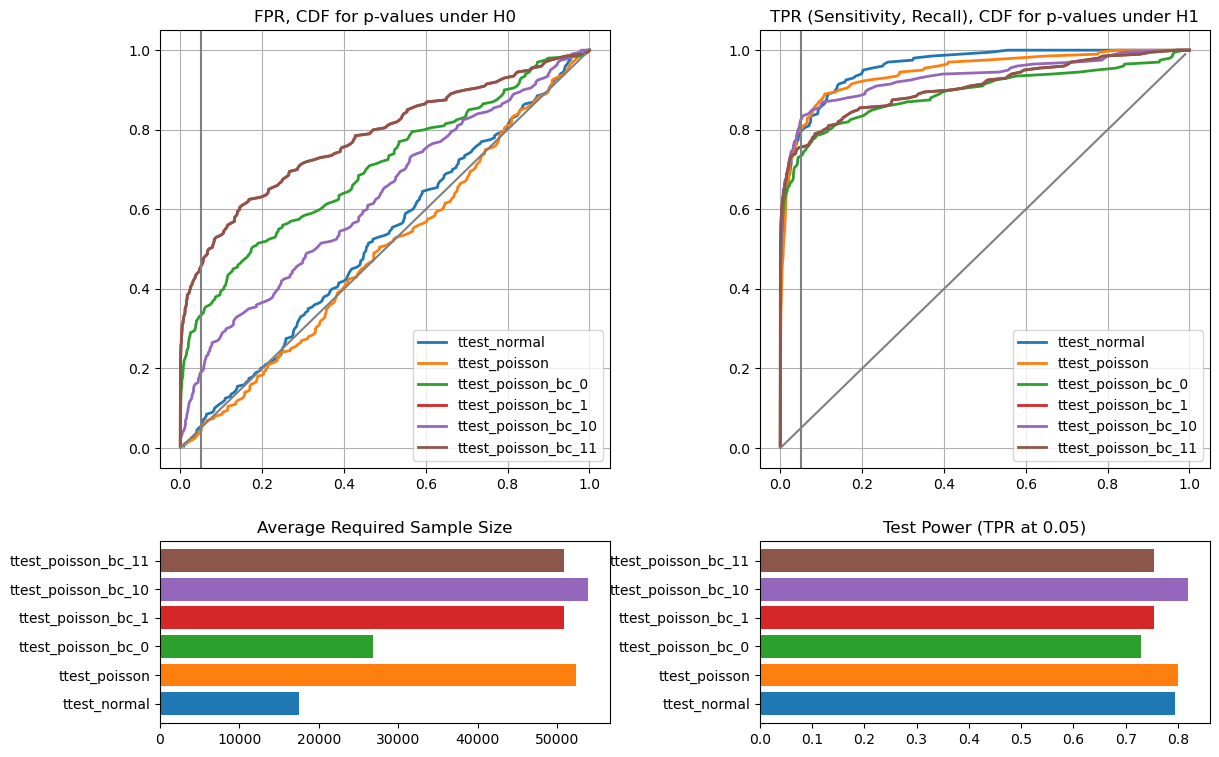

In [72]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [73]:
# Now the same but with log:

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

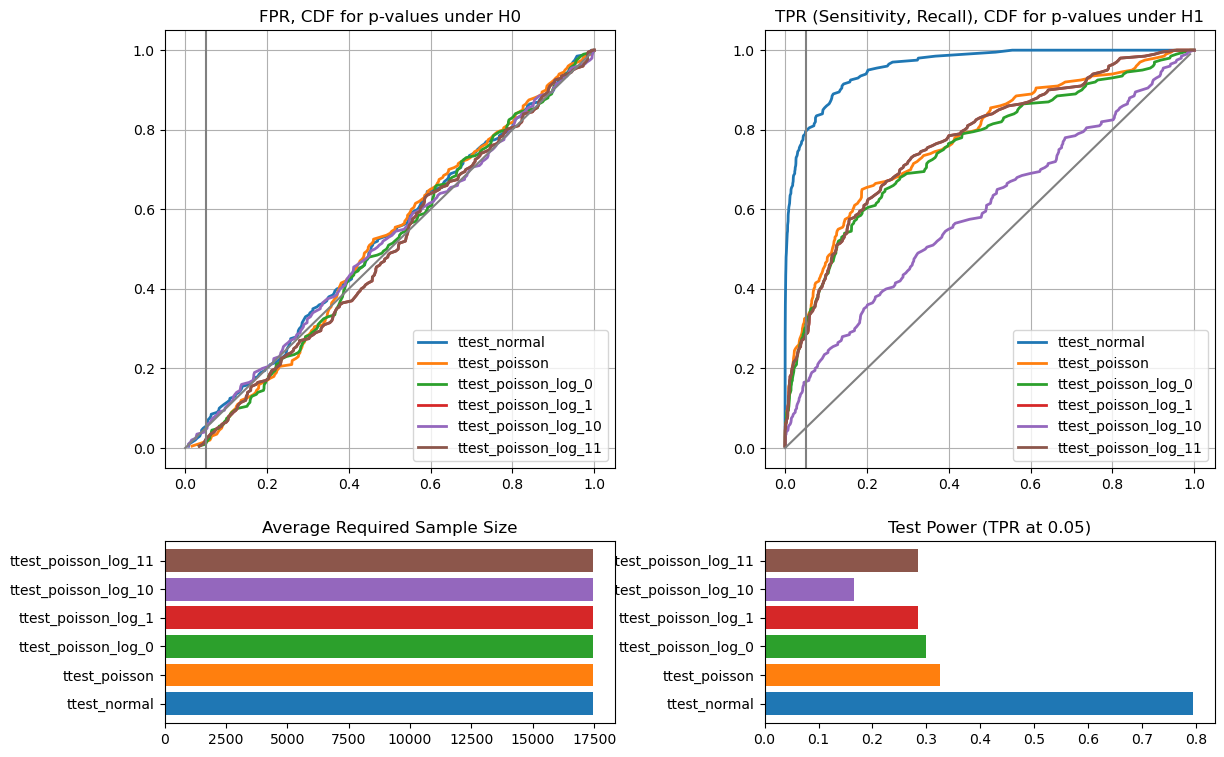

In [74]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [75]:
# Now with own approximated log:

# Now the same but with log:

nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.00911518892246972
mde = 0.005550025763173986
mde = -0.20548123393303253
mde = 0.025276090767041928


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

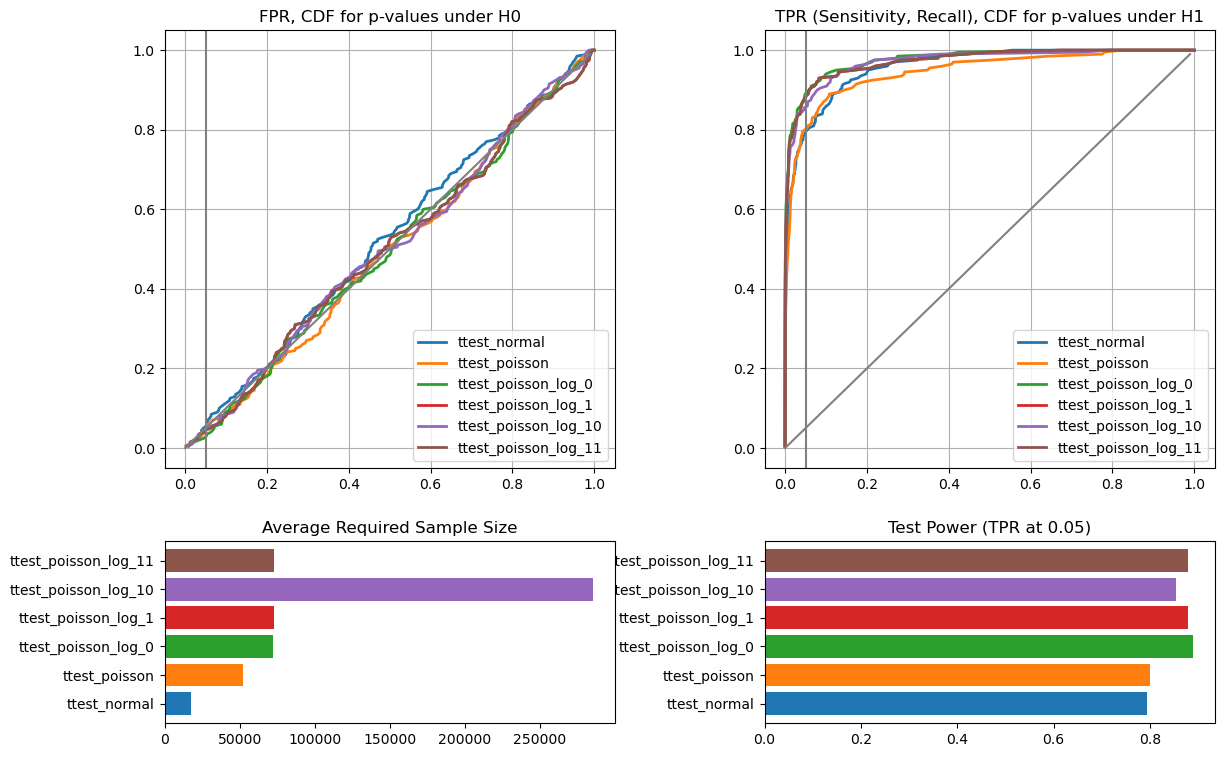

In [76]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [77]:
# Absolutely most difficult situation:

mean = 1
var = 1
mde = 0.01

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

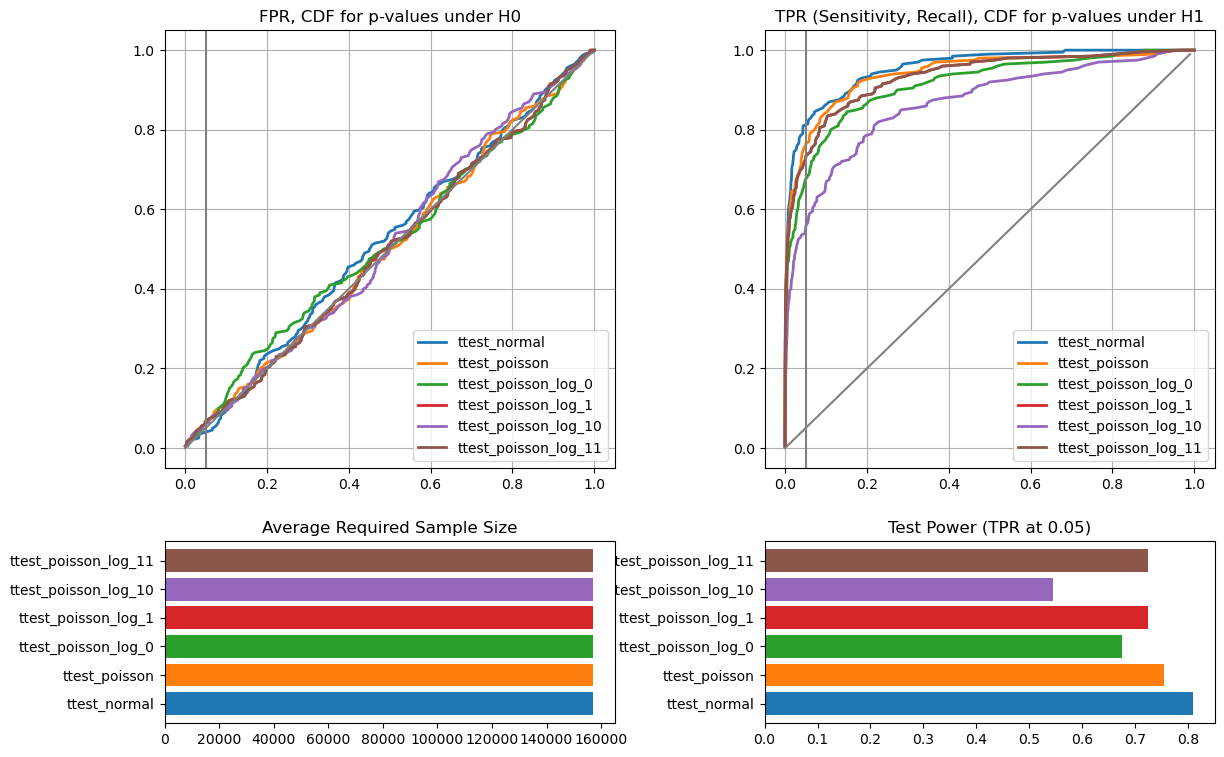

In [78]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [70]:
nobs = 0

n_exps = 200

mean = 1
var = 1

mde = 0.01

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.017956733139762565
mde = 0.008670743202202548
mde = -0.010477931797584846
mde = -0.011640179552197469


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

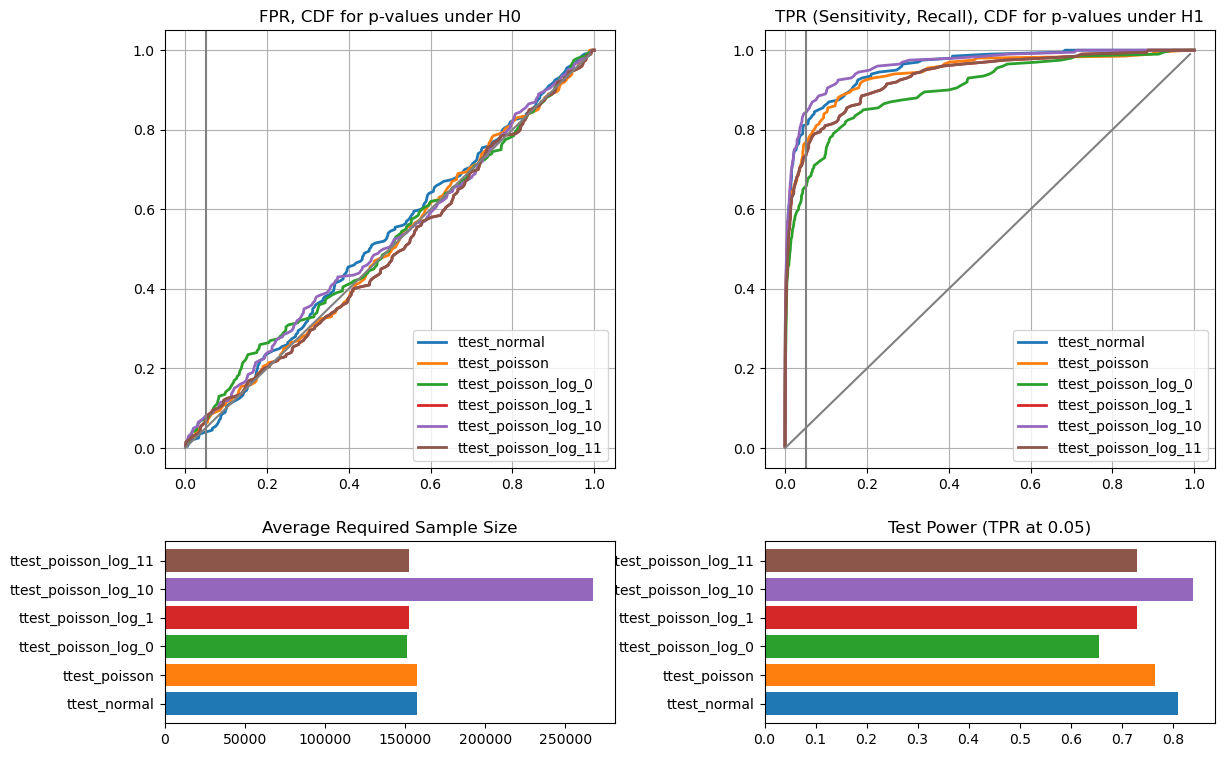

In [71]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [9]:
# MDE-limits

In [50]:
nobs = 0

mean = 2
var = 1
mde = 0.05

n_exps = 200

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.06308634827086075
mde = 0.03500304085518041
mde = -0.13356876646772334
mde = -1.5559913278344129


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

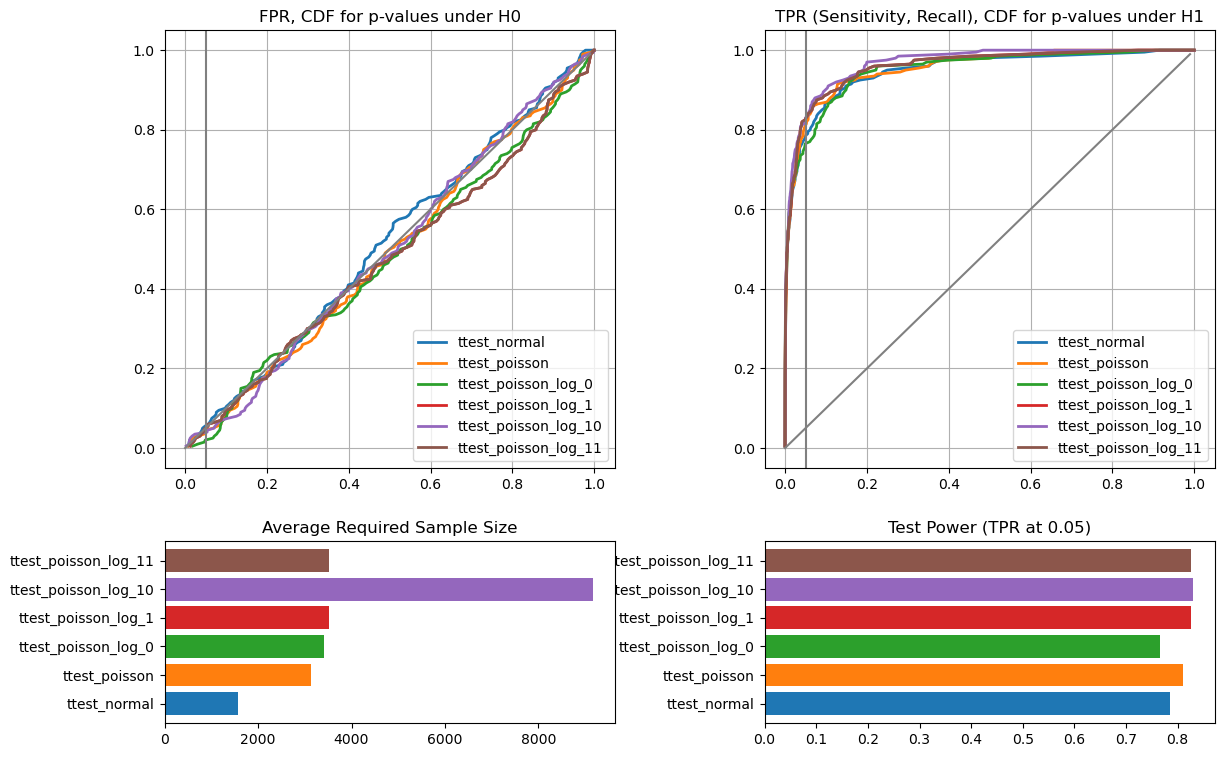

In [51]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [42]:
mde = 0.04

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.050223074530226314
mde = 0.028123791790609972
mde = -0.10980321800276072
mde = -1.2499007485414781


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

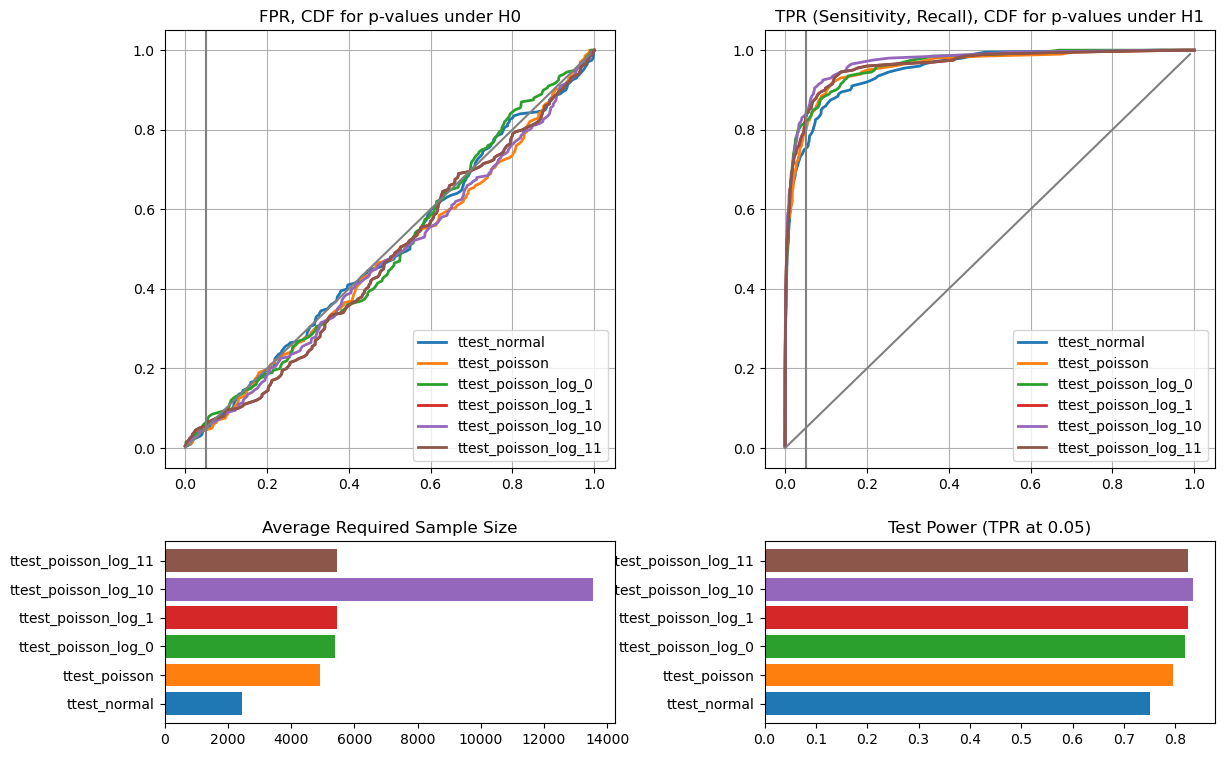

In [43]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [44]:
mde = 0.03

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.03745720161436498
mde = 0.021084159507312992
mde = -0.08349599743878566
mde = -0.9365832612407701


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

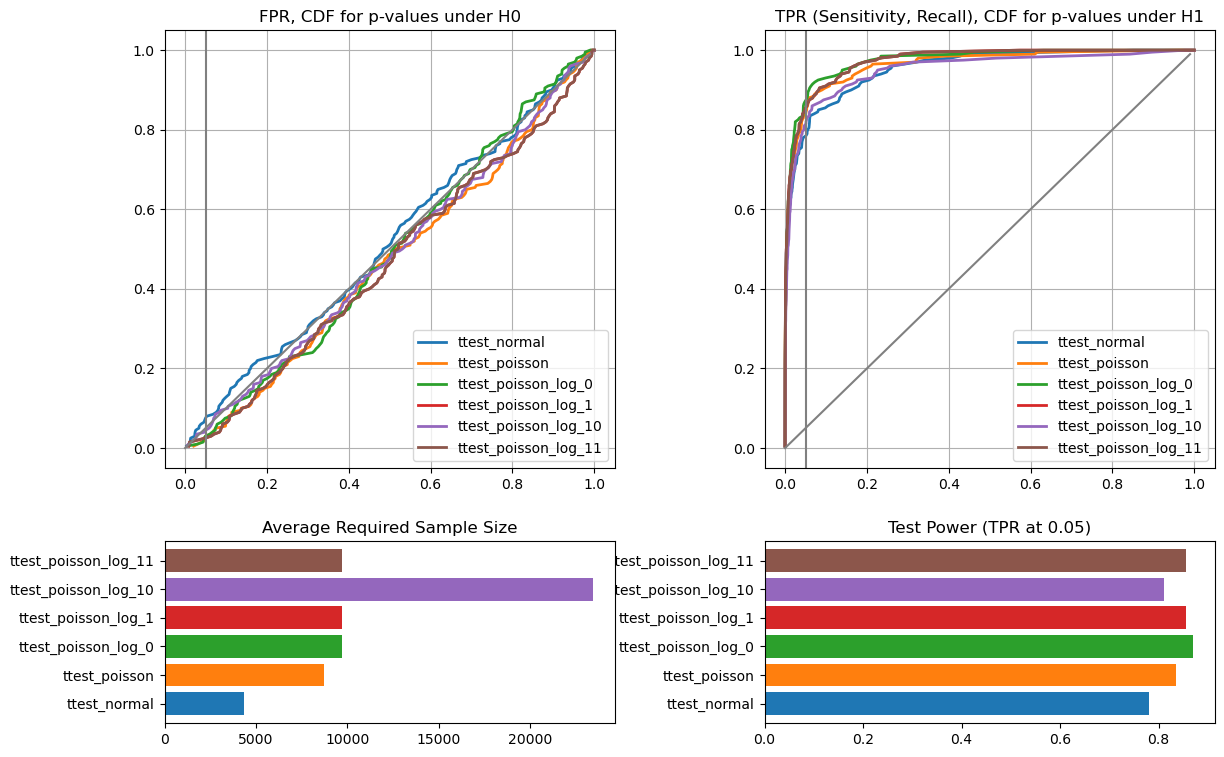

In [45]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [46]:
mde = 0.02

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.024298571819826007
mde = 0.013806303312098233
mde = -0.05595549427161472
mde = -0.6153458404233179


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

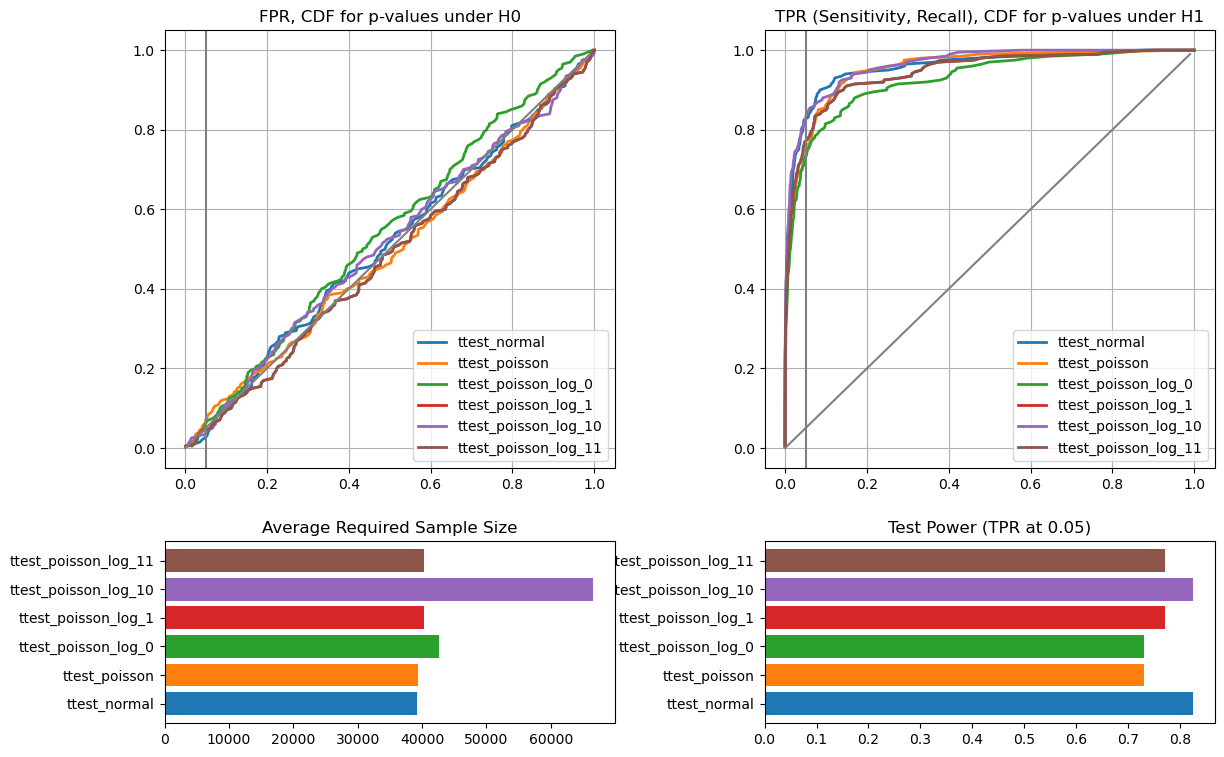

In [33]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [47]:
mde = 0.01

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

mde = 0.011910602290484582
mde = 0.006922925634238868
mde = -0.029623796992259286
mde = -0.30656076536035093


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

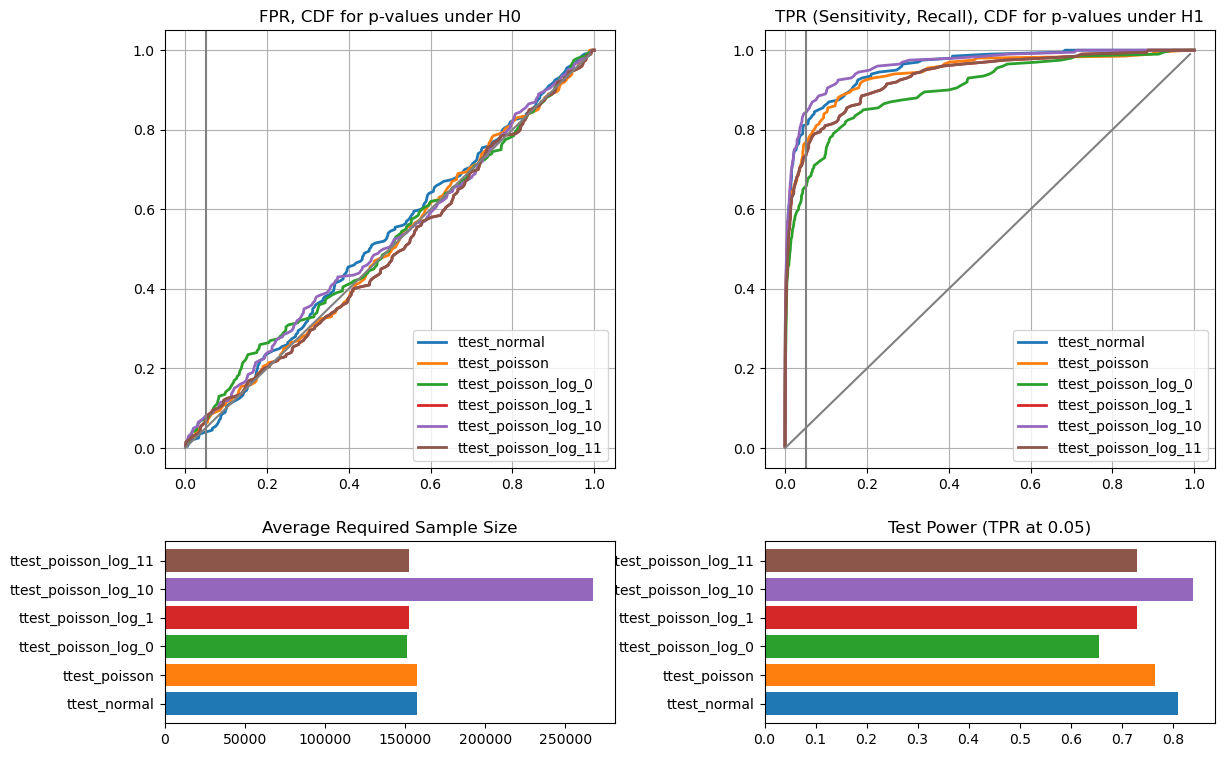

In [35]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

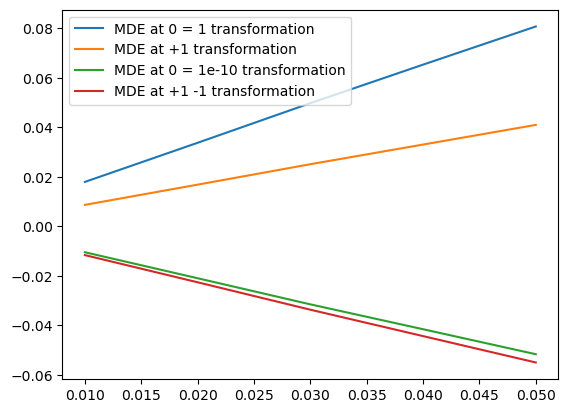

In [36]:
# Show relationship in MDE

x = [0.01,0.02,0.03,0.04,0.05]
y0 = [0.017956733139762565,0.03377721508490627,0.0497940781911947,0.06537310182200558,0.0808048467594187]
y1 = [0.008670743202202548,0.0168519543392199,0.025114899065481446,0.03306268190390825,0.04101358846518025]
y10 = [-0.010477931797584846, -0.020992254699001543, -0.03155246728905465, -0.04160826773207834, -0.05171469650507253]
y11 = [-0.011640179552197469,-0.02262606029584137,-0.033713303703857694, -0.04438862881270553 , -0.05505295871630684]
plt.plot(x, y0, label = "MDE at 0 = 1 transformation")
plt.plot(x, y1, label = "MDE at +1 transformation")
plt.plot(x, y10, label = "MDE at 0 = 1e-10 transformation")
plt.plot(x, y11, label = "MDE at +1 -1 transformation")
plt.legend()
plt.show()

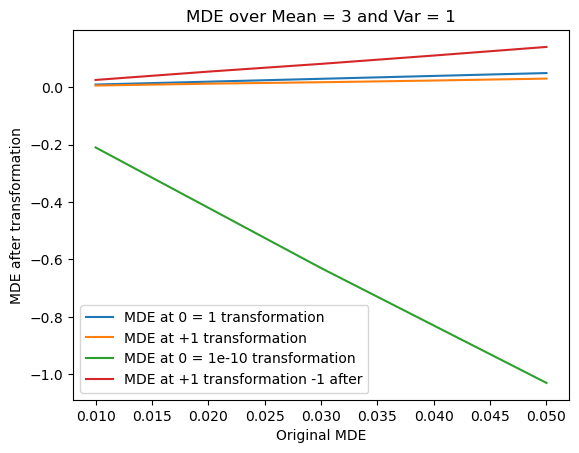

In [76]:
# Mean = 3, var = 1

x = [0.01,0.02,0.03,0.04,0.05]
y0 = [0.009,0.019,0.029,0.039,0.049]
y1 = [0.0055,0.012,0.017,0.023,0.0297]
y10 = [-0.21, -0.42, -0.63, -0.83, -1.03]
y11 = [0.025,0.054,0.081, 0.11 , 0.14]
plt.plot(x, y0, label = "MDE at 0 = 1 transformation")
plt.plot(x, y1, label = "MDE at +1 transformation")
plt.plot(x, y10, label = "MDE at 0 = 1e-10 transformation")
plt.plot(x, y11, label = "MDE at +1 transformation -1 after")
plt.xlabel("Original MDE")
plt.ylabel("MDE after transformation")
plt.title("MDE over Mean = 3 and Var = 1")
plt.legend()
plt.show()

Text(0, 0.5, 'New MDE')

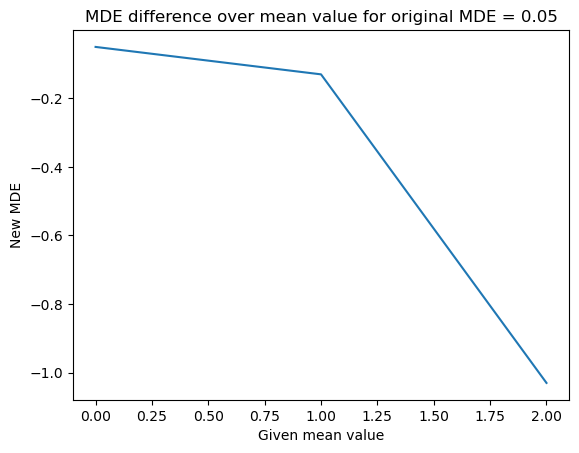

In [74]:
plt.plot([0, 1, 2],[-0.05, -0.13, -1.03])
plt.title("MDE difference over mean value for original MDE = 0.05")
plt.xlabel("Given mean value")
plt.ylabel("New MDE")

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

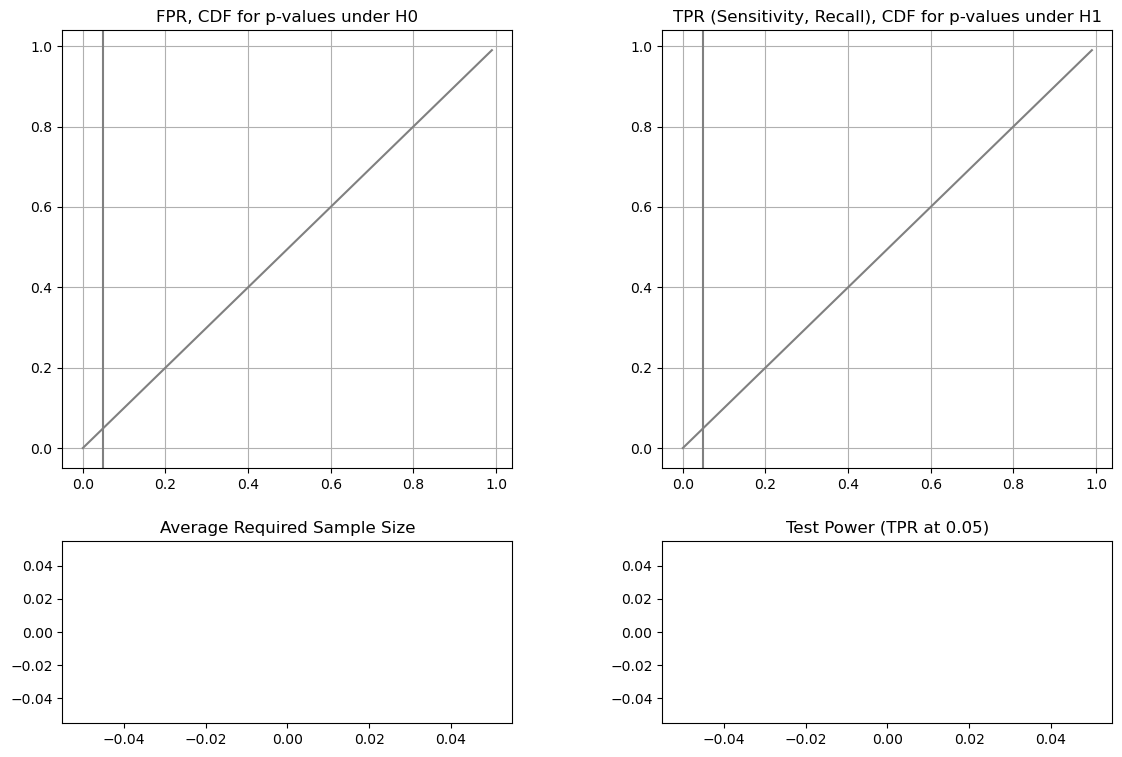

In [64]:
test_res = {}
_ = plot_summary(test_res)

In [111]:
ref_data = rand_gen.laplace(3, (1/np.sqrt(2)), int(points))
print(ref_data)

[1.96078901 2.56015042 2.99533392 ... 1.27149463 3.13031921 1.49690292]
